# MECANISMO CUATRO BARRAS 

## PROBLEMAS VELOCIDAD Y ACELERACIÓN

### PASO 1: MATRIZ JACOBIANA 

Para resolver el problema velocidad, necesitamos otra vez la matriz jacobiana. El método de construcción aparece detallado en el notebook Problema_Posición_4B, por lo que para este caso copiaremos el código de los pasos realizados para poder conseguirla.

In [1]:
#PASO 1
import numpy as np
import math as math
#import array as arr
import pprint  
import matplotlib.pyplot as plt  
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
%matplotlib inline  


print ('MECANISMO DE CUATRO BARRAS')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["L3"] = float (input ('Introduce longitud L3:'))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["XA"] = 0
meca["YA"] = 0
meca["YB"] = 0

# Defino posicion inicial:
q = np.array ([[0.1], [meca["L1"]], [1], [0.2], [meca["theta"]]])
#print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((5,5))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,2] = -2*(meca["XB"]-X2)
    Jacob[2,3] = -2*(0-Y2)

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Jacob[3,4] = meca["L1"]*math.sin(theta)
        Jacob[3,0] = 1
    else:
        Jacob[3,4] = -meca["L1"]*math.cos(theta)
        Jacob[3,1] = 1


    Jacob[4,4] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((5,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 -meca["L2"]**2
    Phi[2] = (meca["XB"]-X2)**2 + Y2**2 - meca["L3"]**2

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Phi[3] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[3] = Y1-meca["L1"]*math.sin(theta)

    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((5,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        theta = q[4]
       
        fi=Phi(q,meca)
        #print ("Phi" + "=")
        #pprint.pprint(fi)
        J = jacob_Phiq(q,meca)
        #print ("jacob" + "=")
        #pprint.pprint(J)
        #rango = np.linalg.matrix_rank(J, 1e-5)
        #print("rango=" + str(rango) + "\n") #Si el rango es menor que el numero de filas no tiene solucion
        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1

        
        #print("error iter" + str(i) + "=")
        #pprint.pprint(error)
    #print("num iters:" + str(i))
    return q

q = resuelve_prob_posicion (q,meca)
J = jacob_Phiq(q,meca)
print ("Jacob=")
pprint.pprint(J)

MECANISMO DE CUATRO BARRAS
Introduce longitud L1:1
Introduce longitud L2:2
Introduce longitud L3:3
Introduce angulo inicial theta:1
Introduce coordenada en x del punto B:2
Jacob=
array([[ 1.08060461,  1.68294197,  0.        ,  0.        ,  0.        ],
       [ 3.0034943 ,  2.64178387, -3.0034943 , -2.64178387,  0.        ],
       [ 0.        ,  0.        , -5.92288968, -0.9588419 ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.84147098],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])


### PASO 2: PROBLEMA VELOCIDAD

Consiste en determinar las velocidades de todas las variables del mecanismo una vez sabemos su posición $q$ y la velocidad de los grados de libertad. 

Partimos de la ecuación:

$\Phi_q  =0 $

Derivando se obtiene:

$\Phi_q \dot{q} + \Phi_t = 0$

Siendo $\dot{q}$ el vector velocidad, $\Phi_q$ el jacobiano y $\Phi_t$ la derivada parcial de las ecuaciones de restricción respecto al tiempo. Para las ecuaciones de sólido rígido el valor de esta derivada es $0$. Solo tendría un valor no nulo la correspondiente al ángulo, que en ese caso tendría la velocidad que nosotros le indiquemos. 

De este modo la expresión quedaría:

$\Phi_q \dot{q} = -\Phi_t$

Este sistema de ecuaciones tiene infinitas soluciones y por tanto hay que ampliar añadiendo un dato conocido de velocidad, lo que se hace añadiendo una fila a la matriz de coeficientes del lado izquierdo y un dato a la columna del lado derecho de la ecuación por cada grado de libertad.

De esta forma llegamos a un sistema de ecuaciones lineal matricial de la forma:

$\mathbf{A} \mathbf{x} = \mathbf{b}$

Habría que multiplicar en ambas partes de la igualdad por la $A$ invertida en el lado izquierdo, del mismo modo que se hizo en el problema de posición. De esta manera quedaría:



$x = -A^{-1} b$

In [2]:
#PASO 2

def resuelve_prob_velocidad(q,meca):
    
    b = np.zeros ((5,1))
    #Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
    b[4]=1
    qp = np.linalg.solve(jacob_Phiq(q,meca),b)
    #print ("qp=")
    #pprint.pprint(qp)
 
    return qp

resuelve_prob_velocidad (q,meca)

array([[-0.84147098],
       [ 0.54030231],
       [ 0.08261205],
       [-0.51030526],
       [ 1.        ]])

### PASO 3: PROBLEMA ACELERACIÓN

El problema aceleración trata de determinar las aceleraciones de todas las variables del mecanismo, conociendo la posición$q$, la velocidad $\dot{q}$ y las aceleraciones de los grados de libertad. 

Partimos la ecuación que se obtiene tras derivar la ecuación inicial para el problema de velocidad, es decir:

$\Phi_q \dot{q} + \Phi_t = 0$

Se deriva por segunda vez:

$\dot{\Phi}_q \dot{q} + \Phi_q \ddot{q} + \dot{\Phi}_t = 0$

Despejamos $\Phi_q \ddot{q}$:

$\Phi_q \ddot{q} = -\dot{\Phi}_t - \dot{\Phi}_q  \dot{q}$


Siendo $\Phi_q$ el jacobiano, $\ddot{q}$ el vector aceleración, $\dot{q}$ el vector velocidad, $\dot{\Phi}_q$ la derivada del jacobiano respecto al tiempo y $\dot{\Phi}_t$ es la derivada de las ecuaciones de restricción con respecto al tiempo, cuyo valor es nulo. Es decir, tendríamos:

$\Phi_q \ddot{q} = - \dot{\Phi}_q  \dot{q}$

Del mismo modo que en el problema velocidad, llamando $b$ al conjunto formado por $\dot{\Phi}_q  \dot{q}$  llegamos a un sistema de ecuaciones lineal matricial:

$ \mathbf{A} \mathbf{x} = \mathbf{b}$

Y despejando la $x$:

$\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}$


El vector velocidad será:

\begin{equation}
\mathbf{q_p} = 
\begin{bmatrix}
\dot{X}_1 \\
\dot{Y}_1\\
\dot{X}_2 \\
\dot{Y}_2 \\
\dot{\theta}\\
\end{bmatrix}
\end{equation}

Por otro lado, para calcular la derivada del jacobiano solo tenemos en cuenta las filas que hacen referencia a las ecuaciones de las coordenadas dependientes, ya que la última que añadimos para poder realizar los cálculos era adicional. Teniendo en cuenta esto, la derivada del jacobiano sería:

1. $Si ~~ \cos (\theta) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & 2\dot{X}_2 & 2\dot{Y}_2 & 0  \\
0 & 0 & 0 & 0 & \theta^2L_1\cos(\theta)\\
\end{bmatrix}
\end{equation}


1. $Si ~~ \cos (\theta) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & 2\dot{X}_2 & 2\dot{Y}_2 & 0  \\
0 & 0 & 0 & 0 & \theta^2L_1\sin(\theta)\\
\end{bmatrix}
\end{equation}


Como ya tenemos $\dot{\Phi}_q$ y $\dot{q}$, podemos calcular $b$. La última fila que añadimos es el valor de la aceleración angular, dato que sabemos de antemano. 


1. $Si ~~ \cos (\theta) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2\\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_1(\dot{Y}_2-\dot{Y}_2) + 2\dot{X}_2(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_2·(\dot{Y}_2-\dot{Y}_1)\\
2\dot{X}_2^2 + 2\dot{Y}_2^2 \\
\dot{\theta}^2·L_1·\cos(\theta)\\
1\\
\end{bmatrix}
\end{equation}

2. $Si ~~ \cos (\theta) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2\\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_1(\dot{Y}_2-\dot{Y}_2) + 2\dot{X}_2(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_2(\dot{Y}_2-\dot{Y}_1)\\
2\dot{X}_2^2 + 2\dot{Y}_2^2 \\
\dot{\theta}^2L_1\sin(\theta)\\
1\\
\end{bmatrix}
\end{equation}

In [3]:
#PASO 3

def resuelve_prob_aceleracion (q,meca):

    b=np.zeros ((5,1))
    qp = resuelve_prob_velocidad (q,meca)

    #Extraer las posiciones
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]
    #Extraer las velocidades
    X1q = qp[0]
    Y1q = qp[1]
    X2q = qp[2]
    Y2q = qp[3]
    thetaq = qp[4]
    
    b[0] = 2*(X1q)**2 + 2*(Y1q)**2
    b[1] = -2*X1q*(X2q-X1q) - 2*Y1q*(Y2q- Y1q) + 2*X2q*(X2q-X1q) + 2*Y2q*(Y2q-Y1q)
    b[2] = 2*X2q**2 + 2*Y2q**2
    
    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        b[3] = thetaq**2 * (meca["L1"] * math.cos(theta))
    else: 
        b[3] =  thetaq**2 * (meca["L1"] * math.sin(theta))
    
    b[4] = 1 #Aceleracion conocida 
    qpp = np.linalg.solve(-jacob_Phiq(q,meca),b)
    #print ("qpp=")
    #pprint.pprint(qpp)	
     
    return qpp

resuelve_prob_aceleracion(q, meca)

array([[ 0.30116868],
       [-1.38177329],
       [ 0.02275194],
       [ 0.41687292],
       [-1.        ]])

### PASO 4: GRÁFICAS DE VELOCIDADES

Vamos a representar por separado la gráfica de la velocidad en cada coordenada $(X_1, ~ Y_1, ~ X_2 ~ e ~ Y_2)$.


VX1=
array([-1.55740772, -1.54462137, -1.50647225, -1.44358679, -1.35699756,
       -1.24812637, -1.11876088, -0.78183279, -0.85514401, -0.91441372,
       -0.95866871, -0.98718231, -0.99948633, -0.99537874, -0.97492698,
       -0.93846687, -0.88659709, -0.82016934, -0.74027437,  1.18588757,
        1.30524998,  1.40318013,  1.47806999,  1.52868987,  1.55420858,
        1.55420712,  1.52868549,  1.47806278,  1.4031702 ,  1.3052375 ,
        1.18587274,  0.74028425,  0.82017774,  0.88660388,  0.93847194,
        0.97493025,  0.99538015,  0.99948586,  0.98717996,  0.95866453,
        0.91440777,  0.85513639,  0.78182363, -1.1187768 , -1.24814006,
       -1.35700879, -1.44359538, -1.50647806, -1.5446243 , -1.55740772])


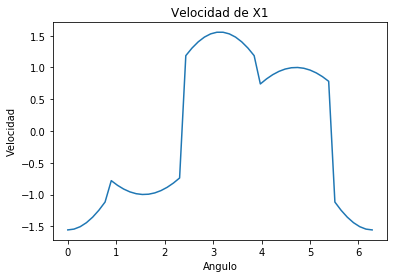

In [4]:
#PASO 4: VELOCIDAD DE X1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)
    VX1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)
        

        VX1 = np.append(VX1, qp[0])
   
        i=i+1
      
    print ("VX1=")
    pprint.pprint(VX1)
 
    plt.plot(th,VX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X1')

    plt.show()
    return 

grafica_velocidad (q,meca)


VY1=
array([ 1.        ,  0.99178998,  0.96729471,  0.92691642,  0.87131812,
        0.80141273,  0.7183481 ,  0.50200906,  0.54908165,  0.58713829,
        0.6155541 ,  0.63386247,  0.64176279,  0.63912534,  0.62599341,
        0.60258265,  0.56927744,  0.52662468,  0.47532471, -0.76144965,
       -0.83809138, -0.9009716 , -0.94905783, -0.98156048, -0.99794585,
       -0.99794491, -0.98155767, -0.9490532 , -0.90096523, -0.83808336,
       -0.76144013, -0.47533105, -0.52663007, -0.56928181, -0.6025859 ,
       -0.62599551, -0.63912624, -0.64176249, -0.63386097, -0.61555141,
       -0.58713448, -0.54907676, -0.50200318,  0.71835832,  0.80142151,
        0.87132533,  0.92692193,  0.96729844,  0.99179185,  1.        ])


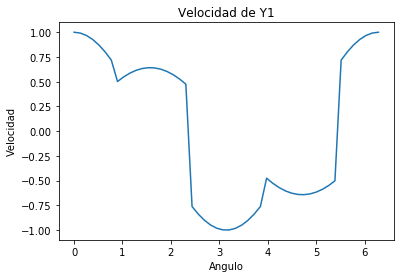

In [5]:
#PASO 4: VELOCIDAD DE Y1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VY1 = np.append(VY1, qp[1])

        i=i+1
      
    print ("VY1=")
    pprint.pprint(VY1)
 
    plt.plot(th,VY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VX2=
array([ 0.15289968,  0.15164437,  0.14789906,  0.14172523,  0.13322426,
        0.12253575,  0.1098352 ,  0.07675703,  0.08395441,  0.08977326,
        0.09411803,  0.09691737,  0.09812533,  0.09772206,  0.09571419,
        0.0921347 ,  0.08704234,  0.08052075,  0.072677  , -0.11642541,
       -0.12814391, -0.13775827, -0.14511064, -0.15008029, -0.15258561,
       -0.15258546, -0.15007986, -0.14510993, -0.1377573 , -0.12814268,
       -0.11642395, -0.07267797, -0.08052157, -0.08704301, -0.09213519,
       -0.09571452, -0.0977222 , -0.09812528, -0.09691714, -0.09411762,
       -0.08977268, -0.08395366, -0.07675613,  0.10983676,  0.1225371 ,
        0.13322537,  0.14172607,  0.14789962,  0.15164466,  0.15289968])


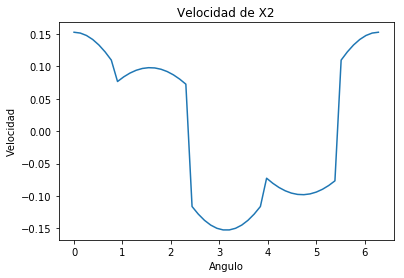

In [6]:
#PASO 4: VELOCIDAD DE X2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VX2 = np.zeros((50,0)) 
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VX2 = np.append(VX2, qp[2])

        i=i+1
      
    print ("VX2=")
    pprint.pprint(VX2)
 
    plt.plot(th,VX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X2')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY2=
array([-0.944481  , -0.93672679, -0.91359148, -0.87545495, -0.82294341,
       -0.75691909, -0.67846613, -0.47413802, -0.51859719, -0.55454096,
       -0.58137915, -0.59867106, -0.60613277, -0.60364174, -0.59123889,
       -0.56912786, -0.53767173, -0.497387  , -0.44893515,  0.71917473,
        0.79156138,  0.85095056,  0.89636709,  0.92706522,  0.9425409 ,
        0.94254001,  0.92706257,  0.89636271,  0.85094454,  0.79155381,
        0.71916573,  0.44894114,  0.4973921 ,  0.53767585,  0.56913094,
        0.59124087,  0.60364259,  0.60613248,  0.59866964,  0.58137662,
        0.55453736,  0.51859257,  0.47413247, -0.67847579, -0.75692739,
       -0.82295022, -0.87546016, -0.913595  , -0.93672856, -0.944481  ])


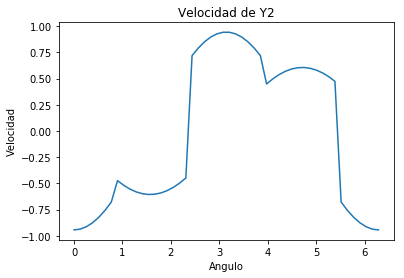

In [7]:
#PASO 4: VELOCIDAD DE Y2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)
        
        #VX1[0,i] = qp[0]

        VY2 = np.append(VY2, qp[3])
        i=i+1
      
    print ("VY2=")
    pprint.pprint(VY2)
 
    plt.plot(th,VY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y2')

    plt.show()
    return 

grafica_velocidad (q,meca)

### PASO 5: GRÁFICAS ACELERACIONES

Haremos el mismo procedimiento que para la velocidad, representando en celdas separadas la aceleración de cada coordenada.

AX1=
array([-4.78259635, -4.49254953, -4.03056547, -3.41913515, -2.69205453,
       -1.89231575, -1.06936993,  0.15834463,  0.33675349,  0.50963284,
        0.67414399,  0.82758567,  0.96743835,  1.09140564,  1.197452  ,
        1.28383614,  1.34913963,  1.39229018,  1.41257925, -3.8523081 ,
       -4.90883837, -5.87395227, -6.69783763, -7.33933494, -7.76842055,
       -7.96797455, -7.93472083, -7.67928087, -7.22534023, -6.60798477,
       -5.87131704, -0.06799024, -0.24806895, -0.42407437, -0.59311646,
       -0.75241955, -0.89936787, -1.03154853, -1.14679111, -1.24320332,
       -1.31920208, -1.37353947, -1.40532328, -3.23635746, -3.75538069,
       -4.22060089, -4.58806022, -4.82067227, -4.89086222, -4.78257347])


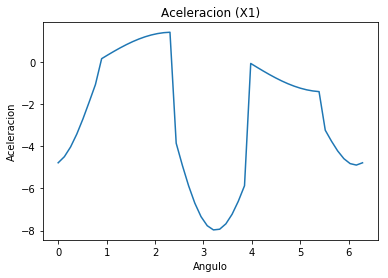

In [8]:
#PASO 5: ACELERACION DE X1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    AX1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        
        
        AX1 = np.append(AX1, qpp[0])

        i=i+1
      
    print ("AX1=")
    pprint.pprint(AX1)	
 
    plt.plot(th,AX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


AY1=
array([-1.        , -1.11966743, -1.22094987, -1.30218426, -1.36203671,
       -1.39952446, -1.41403194, -1.12758443, -1.44355616, -1.73058804,
       -1.97534332, -2.16698737, -2.29781135, -2.36365728, -2.3641177 ,
       -2.30249833, -2.18554708, -2.02296801, -1.82675288,  0.11322559,
        0.2925615 ,  0.46709353,  0.63395587,  0.79040862,  0.93388282,
        1.06202261,  1.17272395,  1.2641691 ,  1.33485653,  1.38362555,
        1.40967537, -0.87611469, -0.96972867, -1.04699969, -1.09733691,
       -1.11213027, -1.08540102, -1.01427506, -0.89924684, -0.74421531,
       -0.55628838, -0.34536781, -0.12354077, -0.02268503, -0.20332156,
       -0.38061953, -0.55166771, -0.71365749, -0.86392897, -1.00001469])


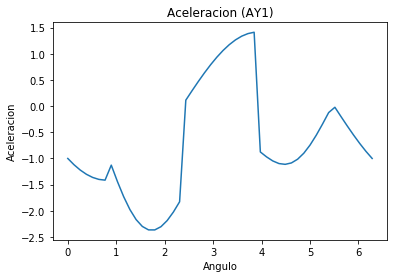

In [12]:
#PASO 5: ACELERACION DE Y1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)


    AY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        

        AY1 = np.append(AY1, qpp[1])

        i=i+1
      
    print ("AY1=")
    pprint.pprint(AY1)
 
    plt.plot(th,AY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (AY1)')

    plt.show()
    return 

grafica_aceleracion (q,meca)


AX2=
array([ 0.64875611,  0.6173498 ,  0.56339365,  0.48965829,  0.40035829,
        0.30088649,  0.19746858,  0.02962046,  0.02097245,  0.01174954,
        0.0017235 , -0.00924111, -0.02116509, -0.03394113, -0.04732979,
       -0.06096536, -0.07437141, -0.08698512, -0.09818898,  0.48211665,
        0.60781331,  0.7221624 ,  0.81899164,  0.89321729,  0.94115612,
        0.96074715,  0.95166876,  0.915344  ,  0.85483388,  0.77462588,
        0.68033178,  0.04716813,  0.0740594 ,  0.09971611,  0.12330658,
        0.14410079,  0.16150477,  0.17508689,  0.18459448,  0.18995993,
        0.19129599,  0.1888808 ,  0.18313368,  0.41021686,  0.48379683,
        0.55042674,  0.60442023,  0.64096428,  0.65645512,  0.64875386])


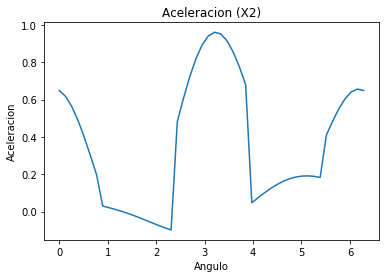

In [15]:
#PASO 5: ACELERACION DE X2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)


    AX2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        

        AX2 = np.append(AX2, qpp[2])

        i=i+1
      
    print ("AX2=")
    pprint.pprint(AX2)
 
    plt.plot(th,AX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


AY2=
array([-2.09801584e+00, -1.93523935e+00, -1.69357576e+00, -1.38414604e+00,
       -1.02343138e+00, -6.32256927e-01, -2.34475056e-01,  2.98233016e-01,
        4.46126981e-01,  5.85663396e-01,  7.12851354e-01,  8.24259048e-01,
        9.17157992e-01,  9.89626640e-01,  1.04060785e+00,  1.06991754e+00,
        1.07820504e+00,  1.06686841e+00,  1.03793120e+00, -1.87099604e+00,
       -2.41335990e+00, -2.91090724e+00, -3.33916890e+00, -3.67785287e+00,
       -3.91204479e+00, -4.03306467e+00, -4.03892566e+00, -3.93436659e+00,
       -3.73045795e+00, -3.44380829e+00, -3.09542410e+00,  1.40053142e-01,
        7.20865616e-02,  2.85354192e-03, -6.83464707e-02, -1.41878487e-01,
       -2.17665635e-01, -2.95116470e-01, -3.73091982e-01, -4.49915605e-01,
       -5.23426672e-01, -5.91074706e-01, -6.50049177e-01, -1.54862046e+00,
       -1.76209070e+00, -1.95039949e+00, -2.09302575e+00, -2.17272572e+00,
       -2.17679081e+00, -2.09800196e+00])


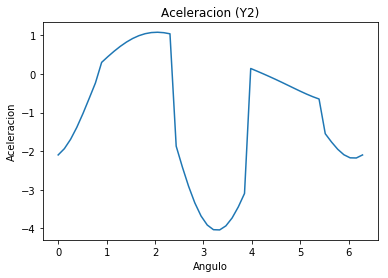

In [14]:
#PASO 5: ACELERACION DE Y2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)


    AY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        

        AY2 = np.append(AY2, qpp[3])
        i=i+1
      
    print ("AY2=")
    pprint.pprint(AY2)	
 
    plt.plot(th,AY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)
